# 1) Download required files 

In [4]:
%%bash
git clone https://github.com/azzubair01/invoice-dataset.git
mv invoice-dataset/dataset ./
mv invoice-dataset/label_map.pbtxt ./
cd dataset
unzip train.zip
mv train images

Couldn't find program: 'bash'


In [2]:
!wget https://raw.githubusercontent.com/hugozanini/object-detection/master/inferenceutils.py
from inferenceutils import *

--2021-02-14 23:22:07--  https://raw.githubusercontent.com/hugozanini/object-detection/master/inferenceutils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2219 (2.2K) [text/plain]
Saving to: ‘inferenceutils.py’

inferenceutils.py   100%[===================>]   2.17K  --.-KB/s    in 0s      

2021-02-14 23:22:08 (12.3 MB/s) - ‘inferenceutils.py’ saved [2219/2219]



# 2) Extract the saved model

In [3]:
%%bash
unzip saved_model_frcnn_v1.zip

Archive:  saved_model_frcnn_v1.zip
   creating: content/inference_graph/saved_model/
   creating: content/inference_graph/saved_model/assets/
   creating: content/inference_graph/saved_model/variables/
  inflating: content/inference_graph/saved_model/variables/variables.index  
  inflating: content/inference_graph/saved_model/variables/variables.data-00000-of-00001  
  inflating: content/inference_graph/saved_model/saved_model.pb  


# 3) Recall model configurations

In [3]:
output_directory = 'inference_graph'
labelmap_path = 'label_map.pbtxt'

import tensorflow as tf
from object_detection.utils import label_map_util
category_index = label_map_util.create_category_index_from_labelmap(labelmap_path, use_display_name=True)
tf.keras.backend.clear_session()
model = tf.saved_model.load(f'content/{output_directory}/saved_model')

NotFoundError: NewRandomAccessFile failed to Create/Open: label_map.pbtxt : The system cannot find the file specified.
; No such file or directory

# 4) Select images to be tested

In [2]:
import pandas as pd
test = pd.read_csv('dataset/test_labels.csv')
#Getting 3 random images to test
images = list(test.sample(n=3)['filename'])
images

FileNotFoundError: [Errno 2] No such file or directory: 'dataset/test_labels.csv'

# 5) Test the detection model

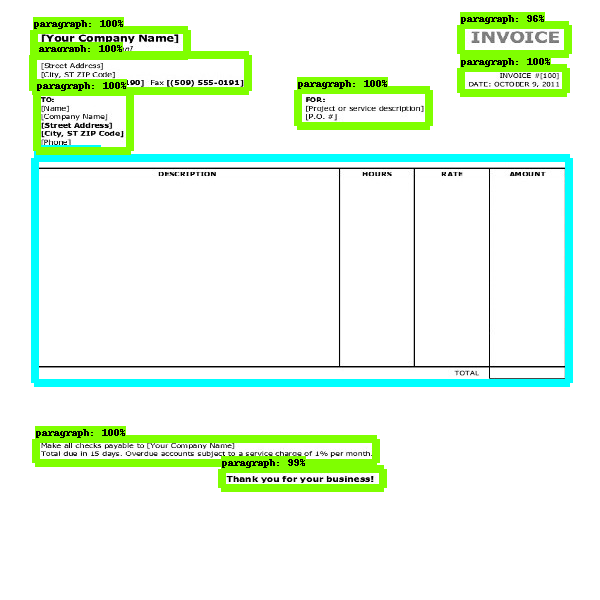

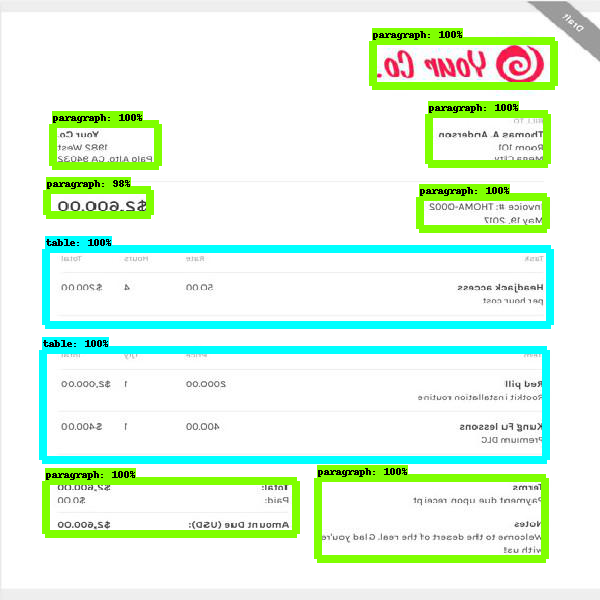

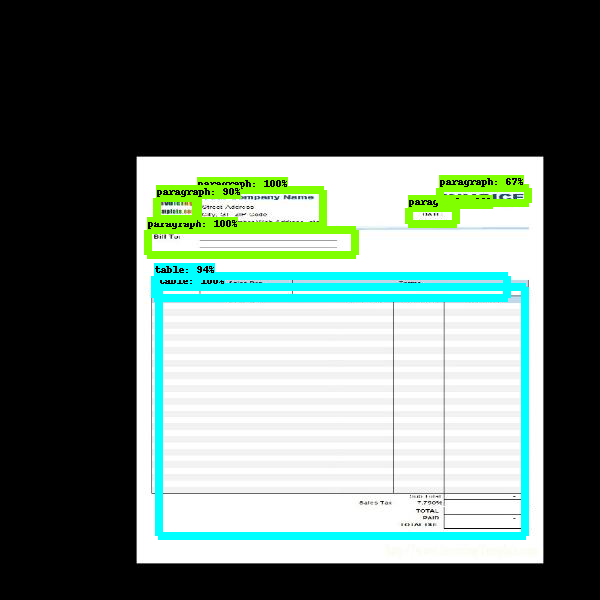

In [6]:
for image_name in images:
    image_np = load_image_into_numpy_array('dataset/images/' + image_name)
    output_dict = run_inference_for_single_image(model, image_np)
    vis_util.visualize_boxes_and_labels_on_image_array(
        image_np,
        output_dict['detection_boxes'],
        output_dict['detection_classes'],
        output_dict['detection_scores'],
        category_index,
        instance_masks=output_dict.get('detection_masks_reframed', None),
        use_normalized_coordinates=True,
        line_thickness=8)
    display(Image.fromarray(image_np))



# 12) Export the predicted coordinates as CSV file

In [ ]:
rows = []

final_dataframe = pd.DataFrame(columns=['Image','Score','Class','Ymin','Xmin','Ymax','Xmax'])
for image_name in images:
  
    image_np = load_image_into_numpy_array('dataset/images/test/' + image_name)
    output_dict = run_inference_for_single_image(model, image_np)

    # store boxes in dataframe!
    cut_off_scores = len(list(filter(lambda x: x >= 0.1, output_dict['detection_scores'])))

    for j in range(cut_off_scores):
        name = image_name
        scores = output_dict['detection_scores'][j]
        classes = output_dict['detection_classes'][j]
        for i in range(1,len(category_index)+1):
            if output_dict['detection_classes'][j] == category_index[i]['id']:
                classes = category_index[i]['name']
        ymin = output_dict['detection_boxes'][j][0]
        xmin = output_dict['detection_boxes'][j][1]
        ymax = output_dict['detection_boxes'][j][2]
        xmax = output_dict['detection_boxes'][j][3]

        row = list([name, scores, classes, ymin, xmin, ymax, xmax])
        rows.append(row)

final_df = pd.DataFrame(rows, columns = ['Image', 'Scores', 'Classes', 'ymin', 'xmin', 'ymax', 'xmax'])
final_df.to_csv('predicted_coordinates.csv', index = False)
final_df